# Analysis of the Data

Assignment 4 is based on transforming a large dataset in text format - over 5000 lines of text.
You will need to scrub (clean) the data and place it into the relevant holder/container objects.
Once in these objects you will see that there are 422 different sets of commit objects.

So your task will be to analyse these 422 objects that are in a list and come up with 3 interesting statistical pieces of information for this dataset with supporting evidence of "interestingness'

You code for calculating the analysis should be documented and tested.
Test should be in a separate file runnable from the command line.

Your statistical analytics conclusions should be in a word document explaining in approximately 500 words the information that you have gleamed from the dataset.

You will be required to submit your code via github along with all documentation and tests.

**Student Name**: Barry Sheppard
**Student Number**: 10387786

#### Load Libraries

In [1]:
from import_gitlog import GitLogCommits
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from heatmap import custom_heatmap # To display time series data as a heatmap

#### Using the GitLogCommits file we load the data into an object

In [2]:
# Create a GitlogCommits object
# open the file - and read all of the lines.
commits = GitLogCommits('changes_python.log')

#### We use the convert_to_dataframe() method to return the object as a dataframe

In [3]:
# Change the commits to a dataframe
df_commits = commits.convert_to_dataframe()

#### We look at a single entry from the dataframe

In [4]:
print(df_commits.iloc[2])

Added                                                              0
Author                                                       Vincent
Changed Files      [drawablw-xxxhdpi:1551688), drawablw-xxxhdpi, ...
Changed Path       [M /cloud/personal/client-international/androi...
Comment                                         [enable all clients]
Date                                             2015-11-27 09:38:09
Deleted                                                            0
Modified                                                           1
Number of Lines                                                    1
Revision                                                    r1551569
Name: 2, dtype: object


---------------

Now we have the data ready it is time to look at three interesting statistical pieces of information. This will be
1. Commits per user
2. File changes per user
2. Time series of each users commits

## 1. Commits per user

In [5]:
print(df_commits[['Author','Revision']].groupby('Author').agg('count'))

                                                 Revision
Author                                                   
/OU=Domain Control Validated/CN=svn.company.net        24
Alan                                                    5
Dave                                                    2
Freddie                                                 7
Jimmy                                                 152
Nicky                                                   5
Thomas                                                191
Vincent                                                26
ajon0002                                                9
murari.krishnan                                         1


This author /OU=Domain Control Validated/CN=svn.company.net is a little long and annoying. So we are going to change that to svn.company.net which is a little shorter and easier to read.

In [6]:
df_commits.replace('/OU=Domain Control Validated/CN=svn.company.net', 'svn.company.net', inplace=True)

Run it again to confirm.

In [7]:
print(df_commits[['Author','Revision']].groupby('Author').agg('count'))

                 Revision
Author                   
Alan                    5
Dave                    2
Freddie                 7
Jimmy                 152
Nicky                   5
Thomas                191
Vincent                26
ajon0002                9
murari.krishnan         1
svn.company.net        24


#### Lets Plot with Seaborn

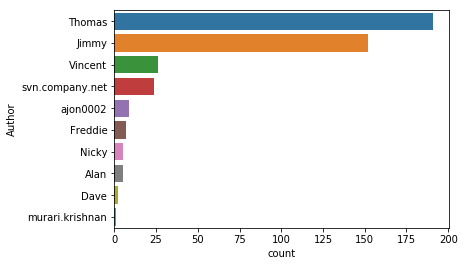

In [8]:
order = df_commits['Author'].value_counts(ascending=False).index
ax = sns.countplot(y="Author", data=df_commits, order=order)

We can see the most commits are by Thomas with Jimmy coming in a close second. Lets start breaking those down to see what our programmers are actually doing. First we look at some of the file adds. Each commit can have multiple files changed at once so even if programmer only commits once they could be changing 100s of files. We can also express this as %.

In [9]:
df_test = df_commits[['Author','Revision']].groupby('Author').agg('count')
total = df_test['Revision'].sum()
df_test['Percentage'] =  100 * df_test[['Revision']] / total
print(df_test)

                 Revision  Percentage
Author                               
Alan                    5    1.184834
Dave                    2    0.473934
Freddie                 7    1.658768
Jimmy                 152   36.018957
Nicky                   5    1.184834
Thomas                191   45.260664
Vincent                26    6.161137
ajon0002                9    2.132701
murari.krishnan         1    0.236967
svn.company.net        24    5.687204


**Why is this interesting?** This is interesting as it is the first indication of how much work is being done. It is boring from the perspective of impressive statistical forumlae but it is core to our understanding of what is happening. The difference between the high performers and lower is also very stark.

-------

## 2. File changes per user

A single commit can be a change of one character or it could be the entire project from start to finish. It reallly depents on how the author is approaching things. To get into this we need to see the number of files Added, Deleted, and Modified during each commit.

In [10]:
df_totals = df_commits.groupby('Author').sum()
df_totals = df_totals.drop(columns='Number of Lines')
df_totals['All Files'] = df_totals['Added'] + df_totals['Deleted'] + df_totals['Modified']

#### All changes to files: Added, Modified, and Deleted

In [11]:
print(df_totals)
df_totals.reset_index(inplace=True)

                 Added  Deleted  Modified  All Files
Author                                              
Alan                 9        6        15         30
Dave                10        0        66         76
Freddie              0        0         9          9
Jimmy              690       66       401       1157
Nicky                0        0         7          7
Thomas              87      663       609       1359
Vincent            260       32        45        337
ajon0002             0        0         9          9
murari.krishnan      0        0         1          1
svn.company.net      0        0        24         24


And lets display that visually

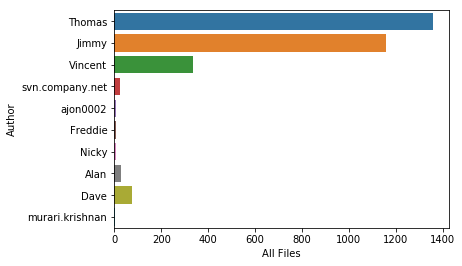

In [12]:
ax = sns.barplot(y='Author', x='All Files', data=df_totals, ci=None, order=order)

Here we can see that Thomas has the majority of files changed closely by Jimmy. Vincent trails both of them and the remainder are below 100 files in total with 4 less than 10. Looking back at the commits plot we can see the svn.company.net has the same number of commits as it does 

To visually inspect we break the following into Added, Modified, and Deleted displayed across three different plots.

In [13]:
# Prepare the data in a format that will be useful for us
df_melt = pd.melt(df_totals.drop(columns='All Files'), id_vars="Author", var_name="File", value_name="Files")

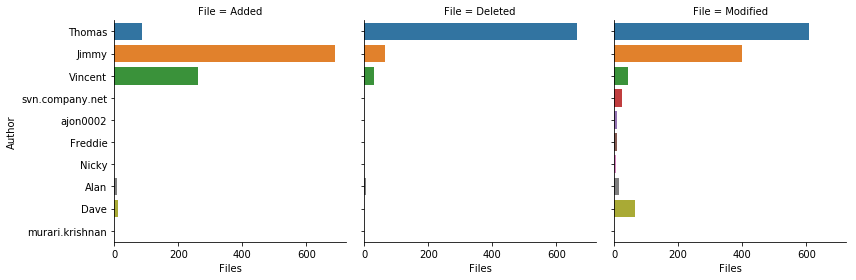

In [14]:
sns.factorplot(x='Files', y='Author', col='File', data=df_melt, kind='bar', order=order)

So Jimmy ads the majority of files. Thomas deletes the majority o f files but also modifies the most. Vincent's contributions primarily come from adding.

In [15]:
df_commit_totals = df_commits[['Author','Revision']].groupby('Author').agg('count')
df_totals.set_index('Author', inplace=True)
df_files_per_commit = pd.concat([df_totals[['All Files']], df_commit_totals], axis=1, sort=False)
df_files_per_commit['Average Files per Commit'] = df_files_per_commit['All Files'] / df_files_per_commit['Revision']
df_files_per_commit = df_files_per_commit.rename(columns={'All Files': 'Total Files', 'Revision': 'Total Commits'})
df_files_per_commit.reset_index(inplace=True)
print(df_files_per_commit)

            Author  Total Files  Total Commits  Average Files per Commit
0             Alan           30              5                  6.000000
1             Dave           76              2                 38.000000
2          Freddie            9              7                  1.285714
3            Jimmy         1157            152                  7.611842
4            Nicky            7              5                  1.400000
5           Thomas         1359            191                  7.115183
6          Vincent          337             26                 12.961538
7         ajon0002            9              9                  1.000000
8  murari.krishnan            1              1                  1.000000
9  svn.company.net           24             24                  1.000000


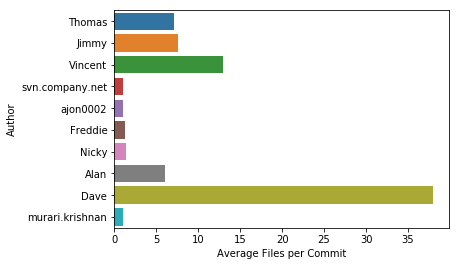

In [16]:
ax = sns.barplot(y='Author', x='Average Files per Commit', data=df_files_per_commit, ci=None, order=order)

**Why is this interesting?** While commits gave us one piece of information, files changed gives us a different one. We can now see that the difference between Jimmy and Thomas is largely down to the files deleteed by Thomas. If we had to choice between them for a single best contributor, before we might have fone with Thomas on commit volume alone, but if we take a file delete as 'lost' work then Jimmy comes out ahead.

----------------

## 3. Time series of each users commits

The raw number of commits isn't a great way to judge a users actual performance. After all, they could make 100 minor commits on one day and nothing on every other day. We saw Dave only commited twice but had 76 files! To get a better idea of what is happening in the team we see how regular posts are.

In [17]:
# # Check when the first date and last commit dates were
print(df_commits['Date'].min())
print(df_commits['Date'].max())

2015-07-13 09:21:48
2015-11-27 16:57:44


In [18]:
print(df_commits[['Author','Date']].groupby('Author').min(),)

                               Date
Author                             
Alan            2015-07-13 11:32:02
Dave            2015-07-23 09:37:01
Freddie         2015-08-26 08:12:56
Jimmy           2015-07-13 11:03:48
Nicky           2015-07-16 19:32:25
Thomas          2015-07-13 09:21:48
Vincent         2015-10-27 13:15:19
ajon0002        2015-11-02 14:55:02
murari.krishnan 2015-08-27 15:18:55
svn.company.net 2015-07-15 13:49:47


In [19]:
print(df_commits[['Author','Date']].groupby('Author').max())

                               Date
Author                             
Alan            2015-07-16 14:37:37
Dave            2015-11-12 20:10:20
Freddie         2015-11-19 13:53:23
Jimmy           2015-11-23 15:02:18
Nicky           2015-08-25 17:19:59
Thomas          2015-11-27 16:57:44
Vincent         2015-11-27 09:38:09
ajon0002        2015-11-02 15:15:35
murari.krishnan 2015-08-27 15:18:55
svn.company.net 2015-11-27 07:05:41


From this we can see that some authors started commiting in July while others stated as late as November. Others stop posting in July while others are still active. So some users with very few posts might actually be very active.

One way to visualise this is with heatmaps. I've updated some custom code in heatmap.py Depending on the author the range gets updated, so yellow doesn't always mean the same thing. The legend below each will show.

### Low commit users

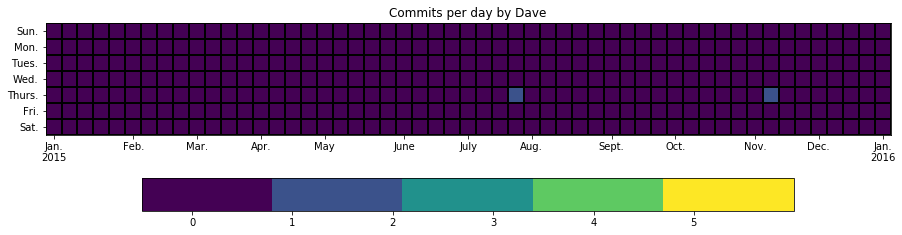

In [20]:
custom_heatmap(df_commits, 'Dave', color_range=5)

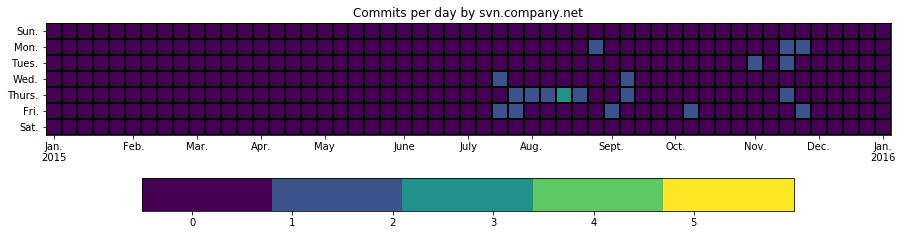

In [21]:
custom_heatmap(df_commits, 'svn.company.net', color_range=5)

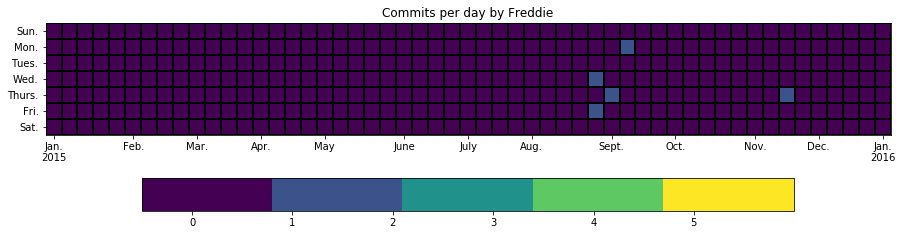

In [22]:
custom_heatmap(df_commits, 'Freddie', color_range=5)

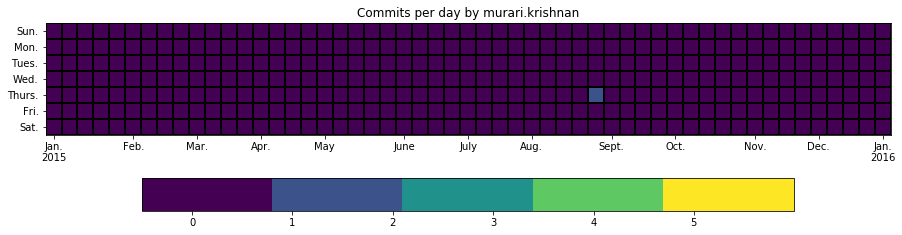

In [23]:
custom_heatmap(df_commits, 'murari.krishnan', color_range=5)

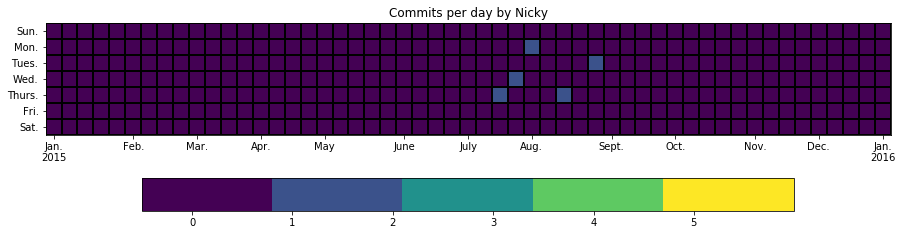

In [24]:
custom_heatmap(df_commits, 'Nicky', color_range=5)

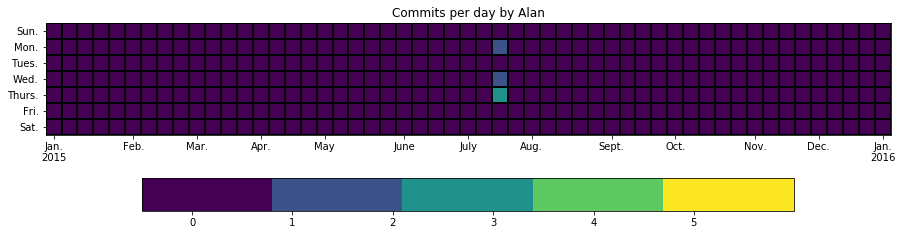

In [25]:
custom_heatmap(df_commits, 'Alan', color_range=5)

### Medium commit users

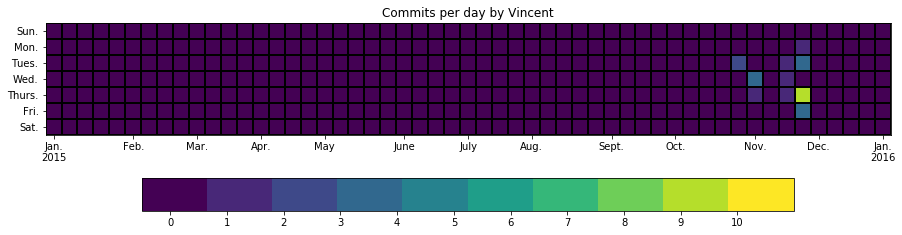

In [26]:
custom_heatmap(df_commits, 'Vincent', color_range=10)

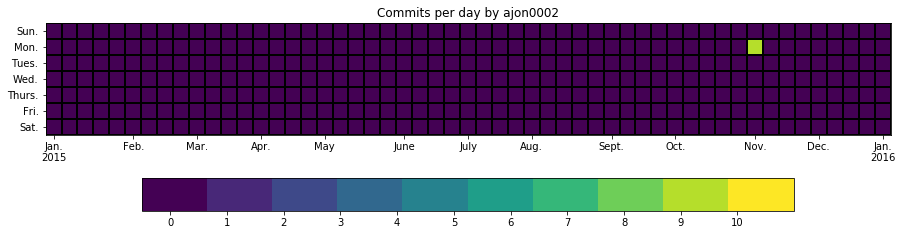

In [27]:
custom_heatmap(df_commits, 'ajon0002', color_range=10)

### High commit users

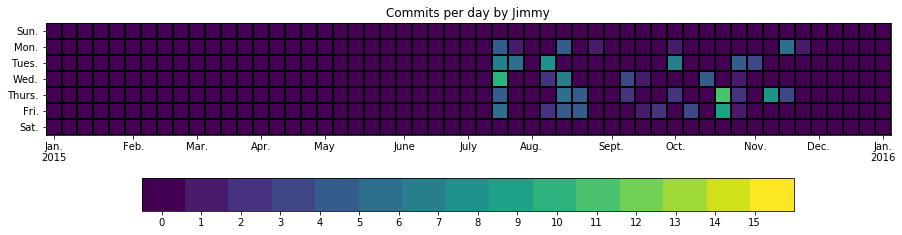

In [28]:
custom_heatmap(df_commits, 'Jimmy', color_range=15)

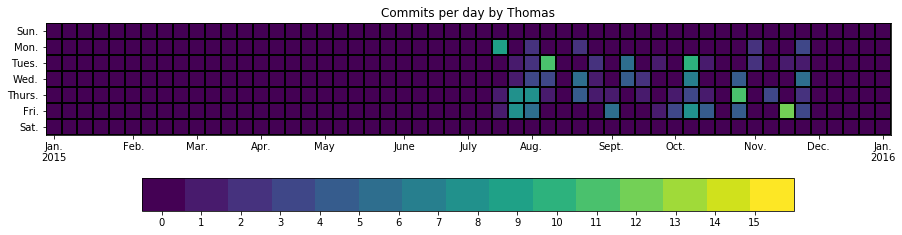

In [29]:
custom_heatmap(df_commits, 'Thomas', color_range=15)

Unsurprisingly Jimmy and Thomas are the most consistent authors and have been with the project for the majojrity of the time. Interestingly, when they are visually compared they seem to work in tandem, with Jimmy having more commits on the days Thomas doesn't and vice-versa. Vincent has also been doing a pretty good job, especially if he only joined the project in November.

**Why is this interesting?** Actually getting to see the days people working does give us a good insight into what is happening. In this case, we need to look and see if Thomas and Jimmy are actually the same person trying to draw down double the salary